# Frontogenesis

$F = \frac{1}{2} \Vert{\nabla \theta}\Vert [D cos(2\beta)-\delta] $

$\theta$ is the potential temperature

$D$ is the total deformation

$\beta$ is the angle between the axis of dilitation and the isentropes

$\delta$ is the divergence


In [1]:
def calc_dx_dy(longitude,latitude,shape='sphere',radius=6370997.):
    ''' This definition calculates the distance between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D or 2D arrays for latitude and longitude
        
        Assumes [Y, X] for 2D arrays
        
        Returns: dx, dy; 2D arrays of distances between grid points 
                 in the x and y direction with units of meters 
    '''
    import numpy as np
    from metpy.units import units
    from pyproj import Geod
    
    if (radius != 6370997.):
        g = Geod(ellps=shape, a=radius, b=radius)
    else:
        g = Geod(ellps=shape)
    
    if (latitude.ndim == 1):
        longitude, latitude = np.meshgrid(longitude,latitude)
    
    dy = np.zeros(latitude.shape)
    dx = np.zeros(longitude.shape)
        
    _, _, dy[:-1,:] = g.inv(longitude[:-1,:],latitude[:-1,:],longitude[1:,:],latitude[1:,:])
    dy[-1,:] = dy[-2,:]
    
    _, _, dx[:,:-1] = g.inv(longitude[:,:-1],latitude[:,:-1],longitude[:,1:],latitude[:,1:])
    dx[:,-1] = dx[:,-2]
    
    xdiff_sign = np.sign(longitude[0,1]-longitude[0,0])
    ydiff_sign = np.sign(latitude[1,0]-latitude[0,0])
    return xdiff_sign*dx*units.meter, ydiff_sign*dy*units.meter

# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [2]:
# Create NCSS object to access the NetcdfSubset
# Data from NOMADS GFS 0.5 deg Analysis Archive
# https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/global-forcast-system-gfs
from siphon.ncss import NCSS
from datetime import datetime
import numpy as np
from netCDF4 import num2date, Dataset
import scipy.ndimage as ndimage
from metpy.units import units
from metpy.calc import shearing_stretching_deformation, potential_temperature, h_convergence
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
################ BEGIN GET DATA ################
year = '2005'
month = '01'
day = '12'
hour = '06'

data = Dataset('netcdf_data/ruc2_252_20050112_0600_000.grb.nc')

In [4]:
#Pull out variables you want to use
# Surface Pressure
pres_var = data.variables['PRES_252_SFC']
# Mean Sea Level Pressure
mslp_var = data.variables['MSLMA_252_MSL']
# 2 m Temperature
temp_var = data.variables['TMP_252_HTGL']
# 10 m U Wind
u_wind_var = data.variables['U_GRD_252_HTGL']
# 10 m V Wind
v_wind_var = data.variables['V_GRD_252_HTGL']

lat_var = data.variables['gridlat_252']
lon_var = data.variables['gridlon_252']

In [5]:
# Get actual data values, remove any size 1 dimensions, and add units
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
pres = pres_var[:].squeeze() * units.Pa
mslp = mslp_var[:].squeeze() * units.Pa
temp = temp_var[:].squeeze() * units.K
u_wind = u_wind_var[:].squeeze() * units('m/s')
v_wind = v_wind_var[:].squeeze() * units('m/s')

# Convert number of hours since the reference time into an actual date
time = datetime(int(year),int(month),int(day),int(hour))

pres_sfc = pres
mslp_hPa = mslp.to('hPa')
temp_2m = temp
u_wind_10m = u_wind
v_wind_10m = v_wind

# Combine 1D latitude and longitudes into a 2D grid of locations
if (lat.ndim < 2):
    lon_2d, lat_2d = np.meshgrid(lon, lat)
else:
    lon_2d = lon
    lat_2d = lat
# Gridshift for barbs
lon_2d[lon_2d > 180] = lon_2d[lon_2d > 180] - 360

################ END GET DATA ################

In [6]:
dx, dy = calc_dx_dy(lon_2d, lat_2d)

thta_sfc = potential_temperature(pres_sfc, temp_2m)

def total_deformation(uwnd, vwnd, dx, dy, dim_order='yx'):
    shrd, strd = shearing_stretching_deformation(uwnd, vwnd, dx, dy, dim_order=dim_order)
    return np.sqrt(shrd**2+strd**2)

# Calculating Frontogenesis
def frontogenesis(thta, uwnd, vwnd, dx, dy, dim_order='yx'):
    # Conversion factor to get to units of K/100km/3h
    CONV = 1.08e4 * 1e5
    
    ddy_thta = np.gradient(thta, dy, axis=0) * units('kelvin/meter') 
    ddx_thta = np.gradient(thta, dx, axis=1) * units('kelvin/meter')
    mag_thta = np.sqrt(ddx_thta**2 + ddy_thta**2)

    shrd, strd = shearing_stretching_deformation(uwnd, vwnd, dx, dy, dim_order=dim_order)
    tdef = total_deformation(uwnd, vwnd, dx, dy, dim_order=dim_order)

    div = h_convergence(uwnd, vwnd, dx, dy, dim_order=dim_order)

    psi = 0.5*np.arctan2(shrd,strd)
    beta = np.arcsin((-ddx_thta*np.cos(psi) - ddy_thta*np.sin(psi))/mag_thta)

    return 0.5 * CONV * mag_thta * (tdef * np.cos(2*beta) - div)

fronto = frontogenesis(thta_sfc, u_wind_10m, v_wind_10m, dx, dy)

/Users/kgoebber/anaconda3/envs/devel/lib/python3.6/site-packages/pint/quantity.py:772: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/Users/kgoebber/anaconda3/envs/devel/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in arcsin
/Users/kgoebber/anaconda3/envs/devel/lib/python3.6/site-packages/pint/quantity.py:1373: RuntimeWarning: invalid value encountered in arcsin
  out = uf(*mobjs)


/Users/kgoebber/anaconda3/envs/devel/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


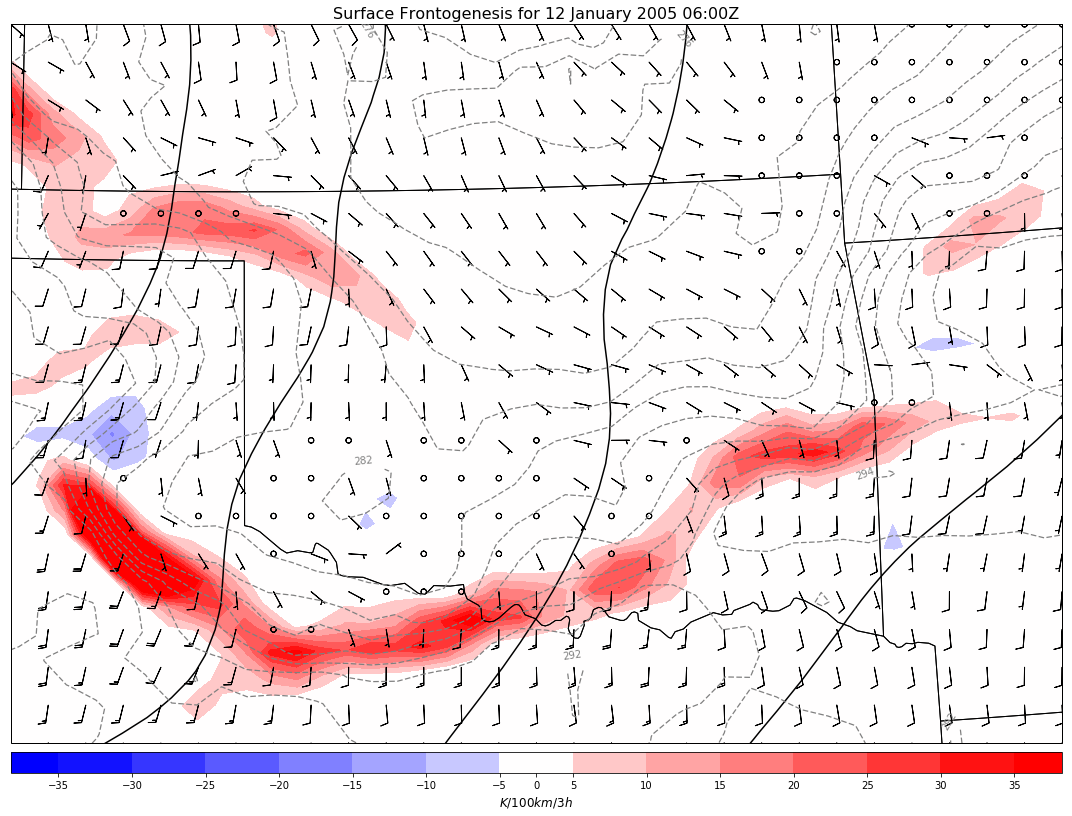

In [7]:
%matplotlib inline

datacrs = ccrs.PlateCarree()
projcrs = ccrs.LambertConformal(central_latitude=[30,60],central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(15,12.5))

# Add the map and set the extent
ax = plt.axes(projection=projcrs)
ax.set_extent([-102., -93., 33., 38.],ccrs.PlateCarree())

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)

# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                               scale='50m',facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)

# Plot MSLP Contours
clevmslp = np.arange(900,1100,4)
cs = ax.contour(lon_2d,lat_2d,mslp_hPa,clevmslp,colors='black',linewidths=1.5,linestyles='solid',
                transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevsfcthta = np.arange(250,350,2)
cs2 = ax.contour(lon_2d,lat_2d,thta_sfc,clevsfcthta,colors='grey',
                 linewidths=1.25,linestyles='dashed',transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
clev_adv = np.arange(-35,36,5)
cf = ax.contourf(lon_2d,lat_2d,fronto,clev_adv[clev_adv!=0],extend='both',cmap='bwr',
                 transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=45, extendrect=True, ticks=clev_adv)
cb.set_label(r'$K/100km/3h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d,lat_2d,u_wind_10m.to('knots').m,v_wind_10m.to('knots').m,length=6,regrid_shape=20,
         transform=datacrs)

plt.title('Surface Frontogenesis for {0:%d %B %Y %H:%MZ}'.format(time), fontsize=16)
plt.tight_layout()
plt.show()